In [1]:
%load_ext autoreload
%autoreload 2

import os
# Run everything on CPU, if GPU is available comment out
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


import sys
sys.path.append("src/")
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from tensorflow import keras
from functools import partial
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
    benchmark_cross_validated_hit_rate,
)
from analysis.scatter_plots import (
    plot_fancy_hexbin_relations
)
from models.rnn import multi_channel_mse

Generating ER datafiles!


In [2]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return 1*x[1] + 1*x[2] + 0*x[0]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "trained_models/final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "trained_models/final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)
print(len(FEATURE_LIST))
print(FEATURE_LIST)
print(y_raw[0])

print(X.shape)


jointlibShape:  (63982, 31)
Unnamed: 0x                                                      0
Peptide                                                    KEDLRDY
MDM2 sum_x                                                0.000207
MDM2 sum_y                                                0.000169
MDM2 sum                                                  0.000061
ER                                                        1.769216
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6483376217869719, 0.700...
RAAx             [1e-08, 0.02564103, 0.03205128, 0.63461538, 0....
propx            [[-1.5, 5.7, 3.0, 0.018, 11.3, 49.5, 0.219, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                        

/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


## Baseline Experimental Rankings

(-11.26699745539576, 12.802835987110129, -0.8329379238887278, 27.369964117469774)


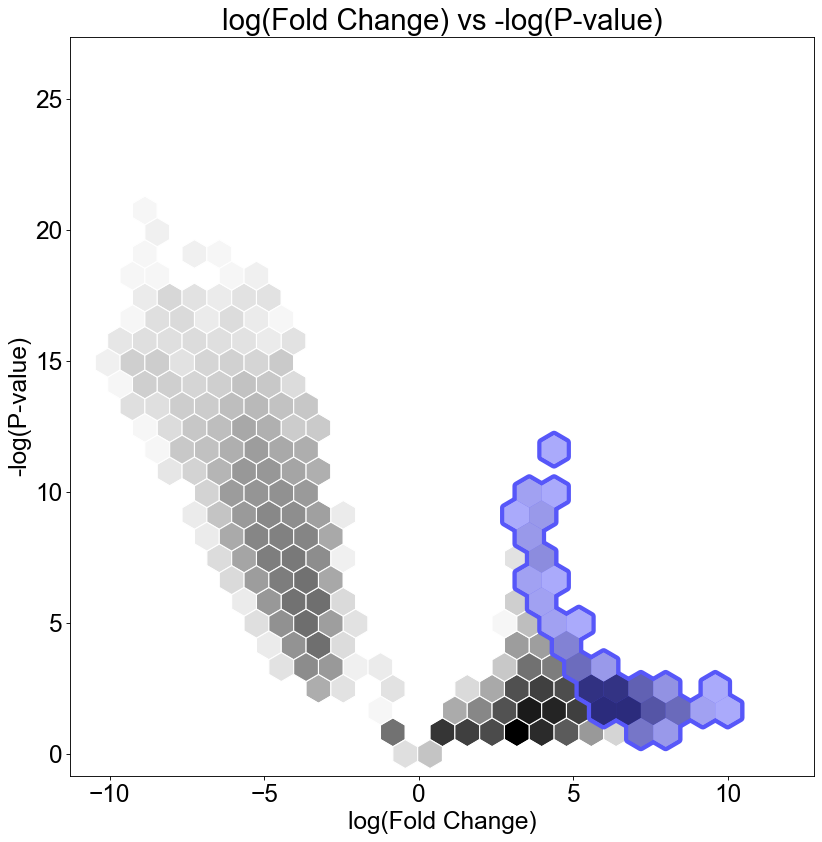

Try  2.1972245773362196
2.1972245773362196
(-11.26699745539576, 12.802835987110129, -0.8329379238887278, 27.369964117469774)


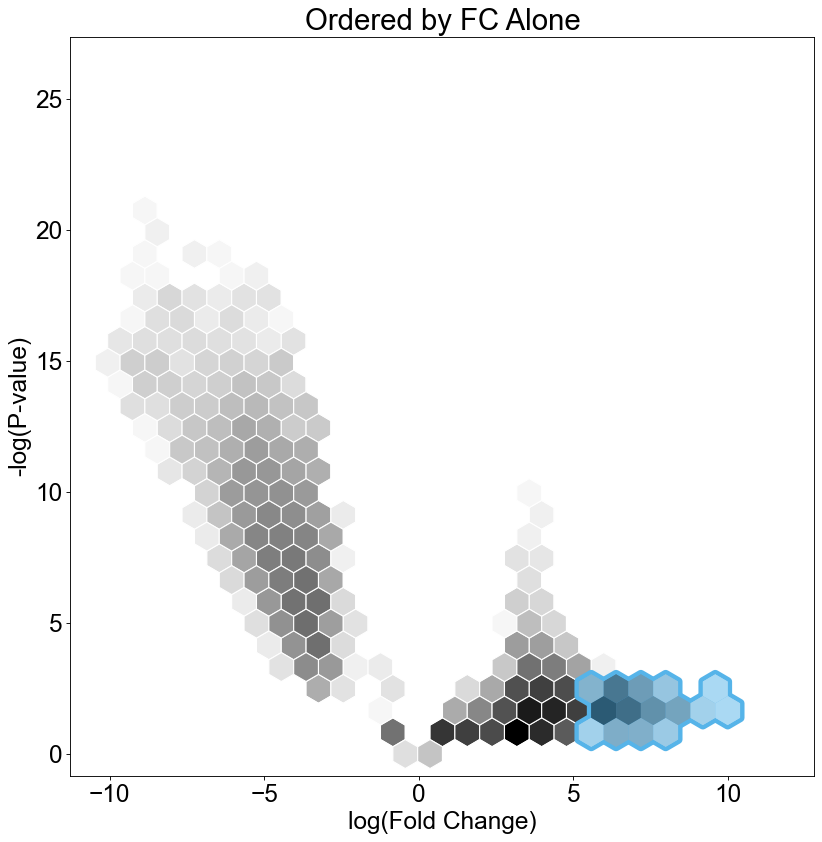

(-12.424972942105276, 18.0343835663439, -11.26699745539576, 12.802835987110129)


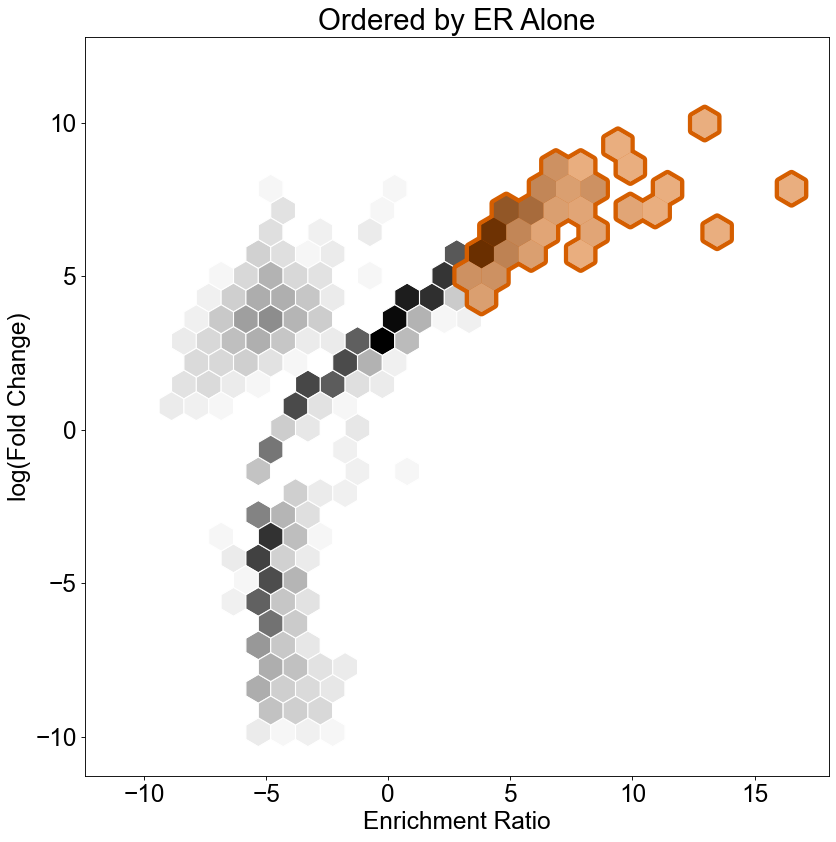

(-12.424972942105276, 18.0343835663439, -11.26699745539576, 12.802835987110129)


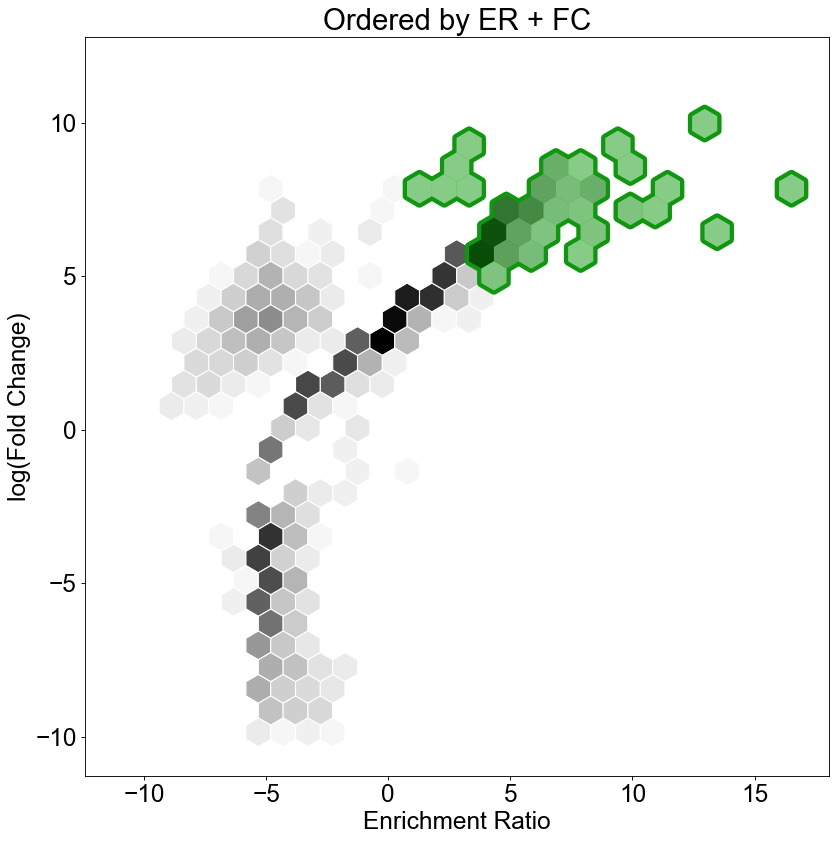

In [3]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)

plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]

print("Try ",y_raw[0][1])
print(fc_alone_mdm2_ordering[0])
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,
    line_color='#56B4E9',
    title='Ordered by FC Alone',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]


plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [1*y[2] + y[1] + 0*y[0] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)


AFCDWFWCS
drop C
max is  75.0
AFCDWFWCS
drop C
max is  67.0
AFCDWFWCS
drop C
max is  95.0


/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))
/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV')

AFCDWFWCS
drop C
max is  89.0


/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/heatmap_analysis.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  all_aa = pd.Series(index=list('ARNDCQEGHILKMFPSTWYV'))


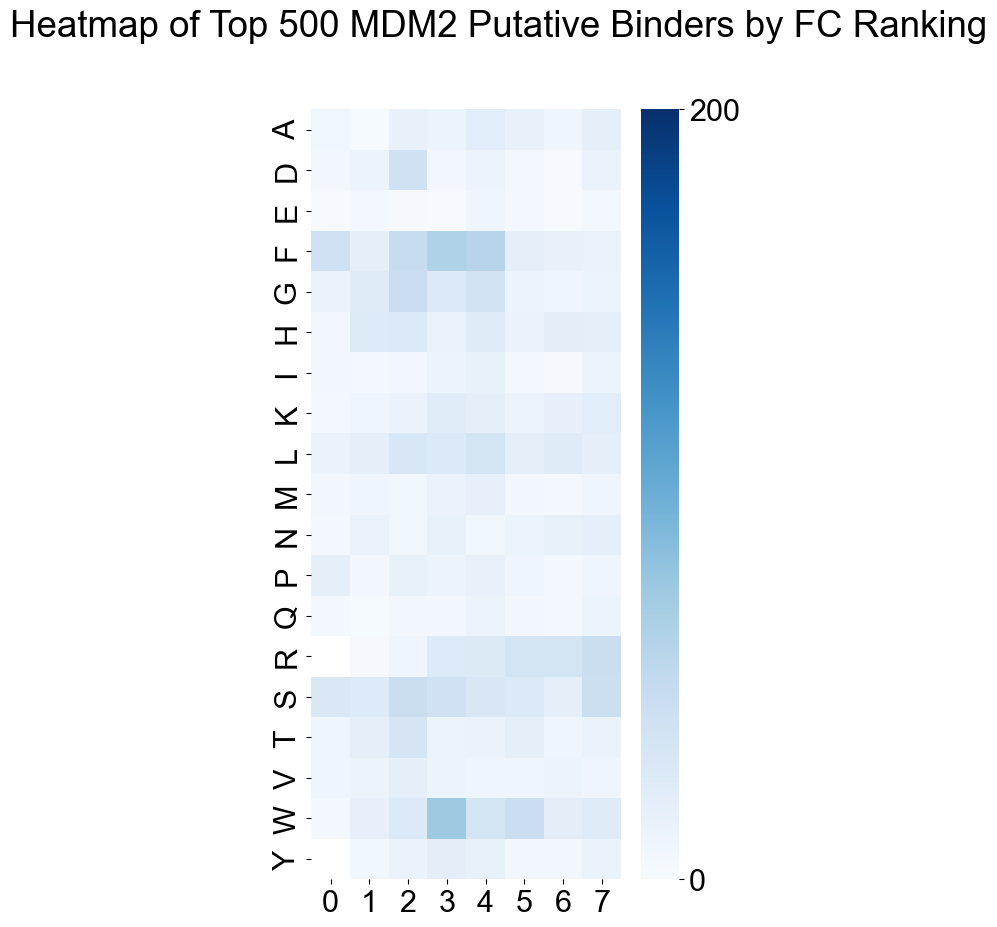

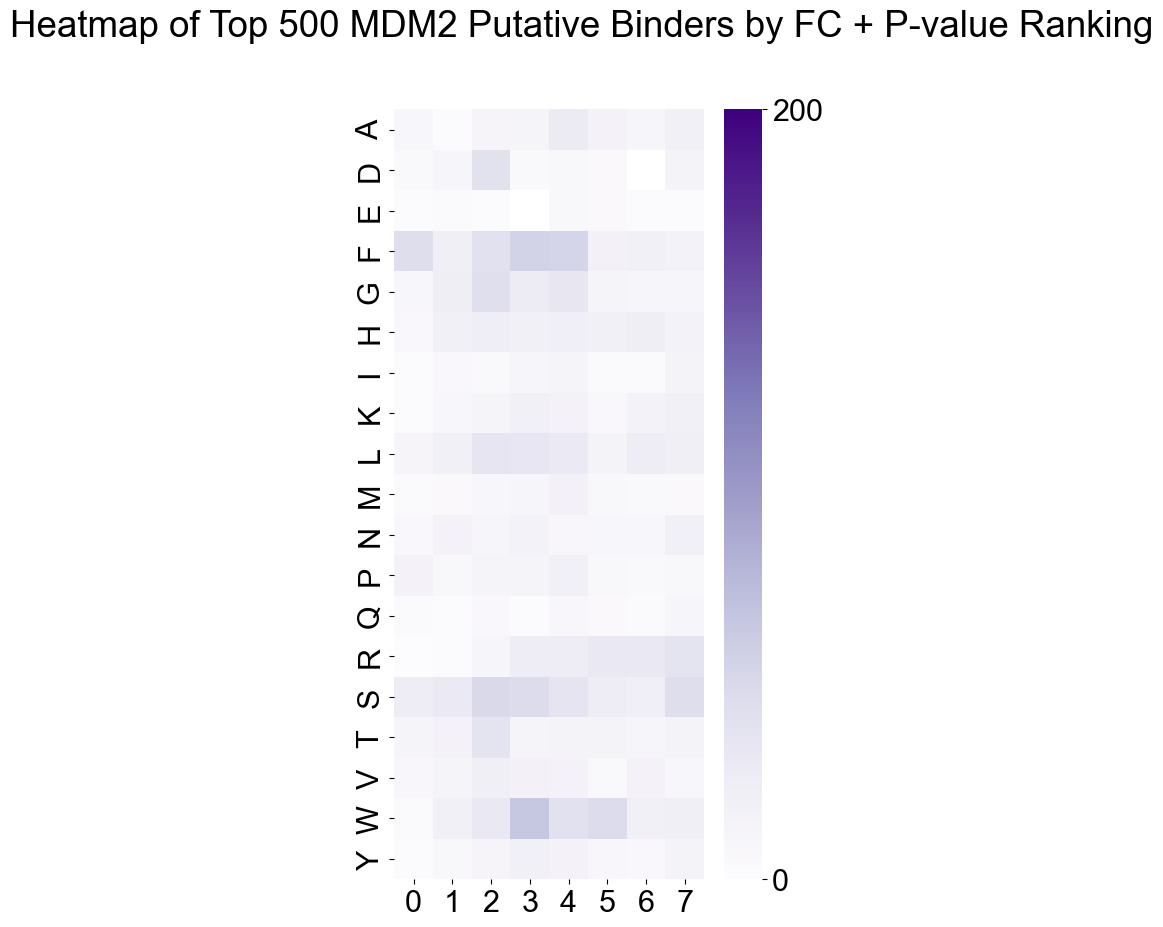

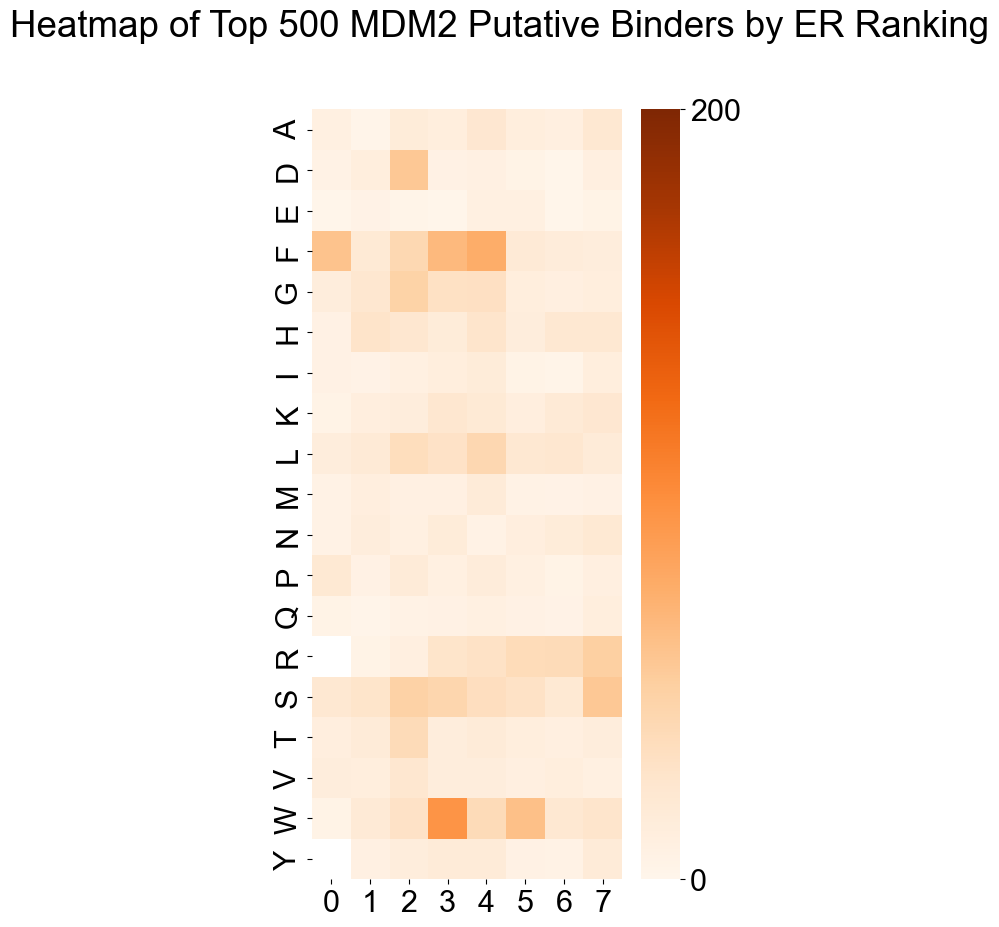

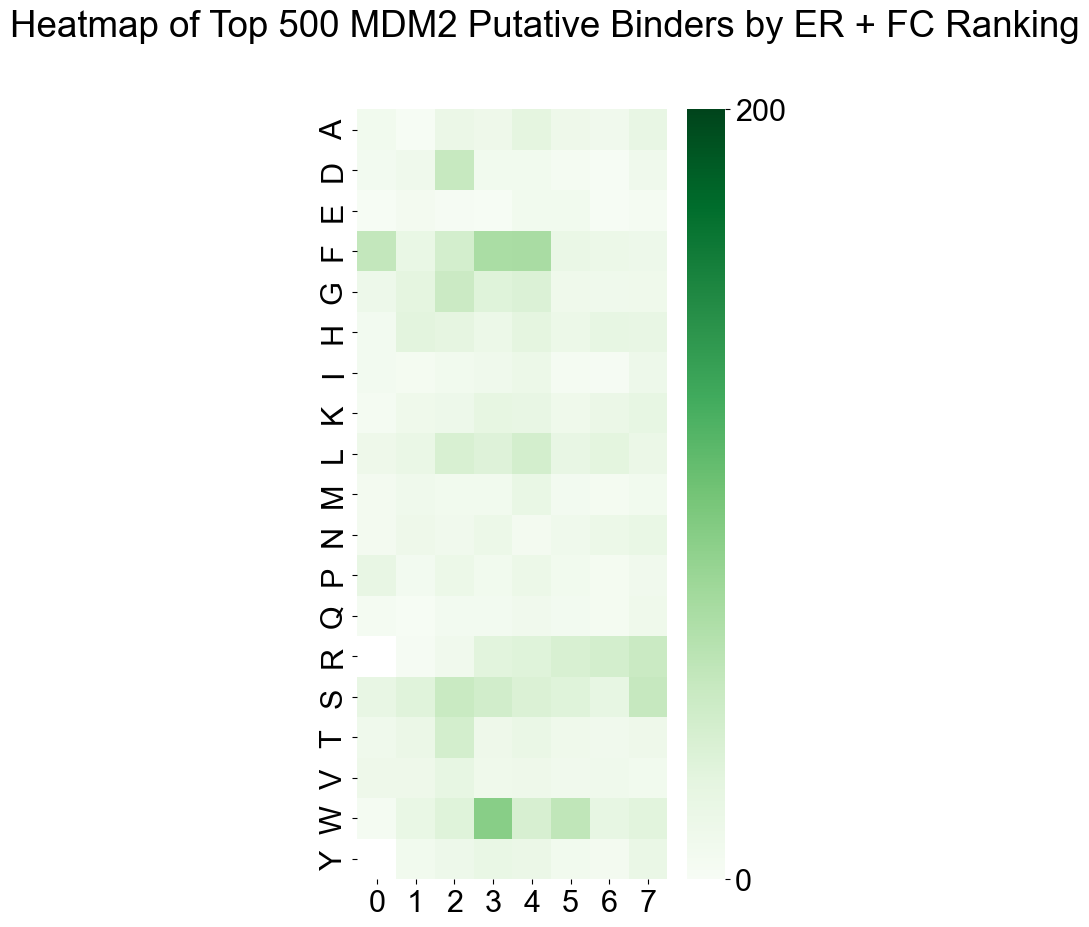

In [4]:
import analysis.heatmap_analysis as heatmap


def show_heatmap_for_top_k(title, ordering, color, peptides=peptides, top_k=top_k_size): #top_k_size=500 for MDM2
    top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
    top_k_peptides = [pep for pep, mask in zip(peptides, top_k_mask) if mask]
    print(top_k_peptides[0])

    heatmap.generate_heatmap(
        top_k_peptides, #list of the peptide AA sequence
        title=title, #title
        vmax=200 if protein_of_interest == 'MDM2' else 600,
        colormap=color,
    )

show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

## BiLSTM Ranking

In [ ]:
print(X.shape)
flatX = X.reshape(32911, 518)
print(flatX.shape)
print(flatX[0])
print


In [ ]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


In [ ]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)


In [ ]:
print(y_raw.shape)

import matplotlib.pyplot as plt
import pandas as pd

# Convert y_raw to DataFrame if it's a NumPy array
if not isinstance(y_raw, pd.DataFrame):
    y_raw = pd.DataFrame(y_raw, columns=["p-value", "FC", "ER"])  # Assign custom column names

# Plot histograms for each column
fig, axes = plt.subplots(1, y_raw.shape[1], figsize=(15, 5))  # Create subplots

for i, column in enumerate(y_raw.columns):
    axes[i].hist(y_raw[column], bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

## Benchmark

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [ ]:
print(len(bilstm_ordering))
print(len(peptides))

# Create a DataFrame
df = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])
df_unordered = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])
df_sorted = df.sort_values(by="BiLSTM Ordering", ascending=False)
# Print the first 10 rows
print(df_sorted.shape)
print(df_unordered.head())

In [ ]:
### Makes fasta of top 1% according to BiLSTM model

# Define output file path
output_file = "MDM2_1percent.fasta"

df_trimmed_BiLSTM = df_sorted.iloc[:, 0].astype(str).str[1:].copy()

print(df_trimmed_BiLSTM.iloc[0:330])

# Open file in write mode
with open(output_file, "w") as fasta_file:
    for idx, sequence in enumerate(df_trimmed_BiLSTM.iloc[0:330]):  # Iterate over sequences
        trimmed_sequence = sequence[1:]  # Remove the first character
        fasta_file.write(f">seq_{idx+1}\n{trimmed_sequence}\n")  # Write FASTA format

print(f"FASTA file saved as {output_file}")

In [ ]:
import subprocess

def run_meme(input_file, output_dir, motif_length=8):
    """Run MEME to find motifs in the input file."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # MEME command
    meme_command = ['meme', input_file, '-minw 4' , '-oc', output_dir]
    # Run the command
    subprocess.run(meme_command, check=True)
    print(f"MEME run completed. Results are in {output_dir}")
    
input_file = output_file  # Path to your input sequences file
output_dir = "meme_output"  # Directory to store the output

run_meme(input_file, output_dir)

In [ ]:
import pandas as pd
import numpy as np

# Create a new DataFrame with the first character removed (without modifying df_sorted)
df_trimmed = df_sorted.copy()
df_unordered_trimmed = df_unordered.copy()

df_trimmed.iloc[:, 0] = df_sorted.iloc[:, 0].str[1:].copy()
df_unordered_trimmed.iloc[:, 0] = df_unordered.iloc[:, 0].str[1:].copy()

# Reset index to prevent row names from affecting calculations
df_trimmed = df_trimmed.reset_index(drop=True)
df_unordered_trimmed = df_unordered_trimmed.reset_index(drop=True)

# Define amino acids for one-hot encoding
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}  # Dictionary mapping amino acids to indices

# Function to one-hot encode a peptide sequence
def one_hot_encode(seq, max_length):
    matrix = np.zeros((max_length, len(amino_acids)))  # Initialize matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:  # Ensure valid amino acid
            matrix[i, aa_to_idx[aa]] = 1  # Set one-hot encoding
    return matrix.flatten()  # Flatten for DataFrame storage

# Get max peptide length
max_length = df_trimmed.iloc[:, 0].str.len().max()

# One-hot encode sequences
encode = lambda df: np.vstack(df.iloc[:, 0].apply(lambda x: one_hot_encode(x, max_length)))
one_hot_order = encode(df_trimmed)
one_hot_unorder = encode(df_unordered_trimmed)

# Create DataFrames with meaningful column names
column_names = [f"pos_{i}_{aa}" for i in range(max_length) for aa in amino_acids]
one_hot_order_df = pd.DataFrame(one_hot_order, columns=column_names)
one_hot_unorder_df = pd.DataFrame(one_hot_unorder, columns=column_names)

# Merge with original data
df_one_hot_order_df = pd.concat([df_trimmed, one_hot_order_df], axis=1)
df_one_hot_unorder_df = pd.concat([df_unordered_trimmed, one_hot_unorder_df], axis=1)
df_flatX_unorder_df = 

# Print shapes and preview data
print(df_one_hot_order_df.shape)
print(df_one_hot_unorder_df.head())


In [ ]:
# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(df_one_hot_order_df["BiLSTM Ordering"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BiLSTM Ordering")
plt.ylabel("Frequency")
plt.title("Histogram of BiLSTM Ordering")

# Show plot
plt.show()

count = (df_one_hot_order_df["BiLSTM Ordering"] > 3.874).sum()
print(f"Number of peptides with BiLSTM Ordering > 3.874: {count}")

In [ ]:
##### PCA clustering
from sklearn.preprocessing import normalize
PCA_First = True
L2norm = False

if PCA_First:
    df_hot_1percent = one_hot_order_df.iloc[:330,:].copy()
    print(df_hot_1percent.shape)
    
    # Exclude non-numeric columns if needed (assuming first two are non-numeric)
    df_numeric_1percent = df_hot_1percent.copy()
    if L2norm: 
        df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

    # Apply PCA without specifying components (to get all possible PCs)
    pca = PCA()
    pca.fit(df_numeric_1percent)

    # Get explained variance ratio
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Determine the number of principal components needed for 95% variance
    num_components_95 = np.argmax(explained_variance >= 0.95) + 1
    print(f"Number of principal components needed to capture 95% variance: {num_components_95}")

    # Plot variance preserved
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="-")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA: Variance Preserved Over Principal Components")
    plt.grid(True)

    # Add threshold line for 95% variance
    plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance")
    plt.legend()
    plt.show()

In [ ]:
##### PCA clustering

if PCA_First:
    # Exclude non-numeric columns if needed
    df_numeric_1percent = df_hot_1percent.copy()  # Assuming first two columns are non-numeric
    df_1_percent_peptides = df_trimmed.iloc[0:330,0].copy()
    print(df_1_percent_peptides) #Output is '(330,)'

    # Perform PCA, reducing to 2 principal components
    if L2norm: 
        df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization
    pca = PCA(n_components=2)
    pc_values = pca.fit_transform(df_numeric_1percent)

    # Create a DataFrame with PC1 and PC2
    df_pca = pd.DataFrame(pc_values, columns=["PC1", "PC2"])
    df_pca["Peptides"] = df_1_percent_peptides  # Add cluster labels back

    # Plot PC1 vs PC2 with peptide labels
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x="PC1", y="PC2", data=df_pca, alpha=0.7)

    # Add peptide labels to the plot
    for i, row in df_pca.iterrows():
        plt.text(row["PC1"], row["PC2"], row["Peptides"], fontsize=8, ha="right", va="bottom")

    # Labels and title
    plt.xlabel("Principal Component 1 (PC1)")
    plt.ylabel("Principal Component 2 (PC2)")
    plt.title("Peptides in PC1 vs PC2 Space (PCA) with Labels")
    plt.grid(True)

    # Show plot
    plt.show()

In [ ]:
##### PCA clustering

if PCA_First:
    df_numeric_1percent = df_hot_1percent.copy()  # Assuming first two columns are non-numeric
    print(df_numeric_1percent.shape)
    if L2norm: 
        df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

    # Perform PCA, reducing to 2 principal components
    pca = PCA(n_components=70)
    pc_values = pca.fit_transform(df_numeric_1percent)

    # Create a DataFrame with PC1 and PC2
    df_pca = pd.DataFrame(pc_values)

    print(df_pca.shape)


In [ ]:
L2norm = False
if PCA_First:
    # Range of clusters to evaluate
    cluster_range = range(2, 30)  # Testing clusters from 2 to 10
    inertia_values = []  # Stores sum of squared distances (for elbow plot)
    silhouette_scores = []  # Stores silhouette scores
    if L2norm: 
        df_pca = normalize(df_pca, norm="l2")  # L2 normalization

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
        cluster_labels = kmeans.fit_predict(df_pca)

        inertia_values.append(kmeans.inertia_)  # Elbow method (sum of squared distances)
        silhouette_scores.append(silhouette_score(df_pca, cluster_labels))  # Silhouette score
    """
    # Iterate through different values of k
    for k in cluster_range:
        kmedoids = KMedoids(n_clusters=k, metric='cosine', random_state=42)
        cluster_labels = kmedoids.fit_predict(df_pca)

        inertia_values.append(kmedoids.inertia_)  # Sum of distances within clusters
        silhouette_scores.append(silhouette_score(df_pca, cluster_labels))  # Silhouette score
    """    
    # Plot Elbow Method
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', label="Elbow Curve")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow Method for Optimal k After PCA")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Silhouette Score
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', label="Silhouette Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score for Optimal k After PCA")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
L2norm = False
# Drop the first two columns (assuming they are non-numeric)
df_features = df_one_hot_order_df.iloc[:330, 2:].copy()
if L2norm: 
    df_features = normalize(df_features, norm="l2")  # L2 normalization
df_1_percent_peptides = df_one_hot_order_df.iloc[:330, 0:2].copy()
print(df_1_percent_peptides.shape)

# Range of clusters to evaluate
cluster_range = range(2, 30)  # Testing clusters from 2 to 20
inertia_values = []  # Stores sum of squared distances (for elbow plot)
silhouette_scores = []  # Stores silhouette scores

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    cluster_labels = kmeans.fit_predict(df_features)
    
    inertia_values.append(kmeans.inertia_)  # Elbow method (sum of squared distances)
    silhouette_scores.append(silhouette_score(df_features, cluster_labels))  # Silhouette score
"""
for k in cluster_range:
    kmedoids = KMedoids(n_clusters=k, metric='cosine', random_state=42)
    cluster_labels = kmedoids.fit_predict(df_features)

    inertia_values.append(kmedoids.inertia_)  # Sum of distances within clusters
    silhouette_scores.append(silhouette_score(df_pca, cluster_labels))  # Silhouette score
"""

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', label="Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', label="Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
df_pca["Cluster"] = kmeans.fit_predict(df_pca)
print(df_pca)

In [ ]:
df_pca1 = df_pca.copy()
kmedoids = KMedoids(n_clusters=9, metric='cosine', random_state=42)
df_pca1["Cluster"] = kmedoids.fit_predict(df_pca)
print(df_pca1)

In [ ]:
##### PCA clustering

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster_pca = df_pca.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster_pca.shape}")

Full_Trimmed_one_hot = one_hot_unorder_df.copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means_pca = Top_1_with_cluster_pca.groupby("Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means_pca.shape}")
print(cluster_means_pca)

# Inverse transform PCA-reduced cluster means back to approximate one-hot encoding
approx_one_hot_pca = pca.inverse_transform(cluster_means_pca)
approx_one_hot_pca = np.array(approx_one_hot_pca)
approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, columns=df_hot_1percent.columns, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(Top_1_with_cluster_pca["Cluster"].value_counts())

In [ ]:
# Non-PCA

# Drop the first two columns (assuming they are non-numeric)
df_1_p_features = df_one_hot_order_df.iloc[:330, 2:].copy()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
if L2norm: 
    df_1_p_featuresNorm = normalize(df_1_p_features, norm="l2")  # L2 normalization
    df_1_p_features["Cluster"] = kmeans.fit_predict(df_1_p_featuresNorm)
else:
# Perform K-means clustering with 3 clusters
    df_1_p_features["Cluster"] = kmeans.fit_predict(df_1_p_features)
    
print(df_1_p_features)

"""
kmedoids = KMedoids(n_clusters=6, metric='cosine', random_state=42)
df_1_p_features["Cluster"] = kmedoids.fit_predict(df_1_p_features)
print(df_1_p_features)
"""
# Save the results (optional)
#df_trimmed_one_hot.to_csv("peptides_clustered.csv", index=False)

#print("K-means clustering complete. Cluster labels added to 'peptides_clustered.csv'.")

In [ ]:
#Non-PCA

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster = df_1_p_features.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster.shape}")
#print(Top_1_with_cluster.head())

Full_Trimmed_one_hot = one_hot_unorder_df.copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means = Top_1_with_cluster.groupby("Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means.head(5))

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = cluster_means.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot.iloc[i * num_amino_acids : (i + 1) * num_amino_acids].values
        
        # Check if the one-hot encoding is correctly structured
        if len(pos_one_hot) != num_amino_acids:
            print(f"Warning: Unexpected length at position {i}: {len(pos_one_hot)}")
            continue
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Generate average peptide sequence for each cluster
average_sequences = cluster_means.apply(one_hot_to_sequence, axis=1)

# Print the average peptide sequences
for cluster, avg_seq in zip(cluster_means.index, average_sequences):
    print(f"Cluster {cluster}: {avg_seq}")
    
Top_1_with_cluster["Cluster"].value_counts()

In [ ]:
# PCA and similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

# Convert to NumPy arrays
peptide_encodings = np.array(df_one_hot_unorder_df.iloc[:, 2:])  

# Ensure cluster_means is a NumPy array
if isinstance(cluster_means, dict):
    raise TypeError("Error: 'cluster_means' is a dictionary. Convert it to a NumPy array or DataFrame.")
cluster_means_array = np.array(cluster_means)
cluster_means_array_pca = np.array(approx_one_hot_pca) 

# Function to compute Pearson correlation efficiently
def compute_pearson_matrix(peptides, clusters):
    return np.array([[pearsonr(peptide, cluster)[0] for cluster in clusters] for peptide in peptides])

# Function to compute similarity metrics
def compute_similarity_metrics(peptides, clusters):
    return {
        "Pearson": compute_pearson_matrix(peptides, clusters),
        "Cosine": cosine_similarity(peptides, clusters),
        "Euclidean": -cdist(peptides, clusters, metric='euclidean')  # Negative for similarity convention
    }

# Compute similarities for both normal and PCA cluster means
similarity_results = {metric: compute_similarity_metrics(peptide_encodings, clusters)
                      for metric, clusters in {"Normal": cluster_means_array, "PCA": cluster_means_array_pca}.items()}

# Convert similarity scores to DataFrames
df_similarity = {}
for metric, results in similarity_results.items():
    for sim_type, scores in results.items():
        df_similarity[f"{sim_type}_{metric}"] = pd.DataFrame(scores, 
            columns=[f"Similarity_to_Cluster_{i}" for i in range(scores.shape[1])])

# Create DataFrame for best similarity scores and their corresponding clusters
df_re_ranked = df_unordered_trimmed.copy()

for key, df in df_similarity.items():
    df_re_ranked[f"Max_{key}"] = df.max(axis=1)  # Highest similarity score
    df_re_ranked[f"Best_{key}_Cluster"] = df.idxmax(axis=1)  # Best-matching cluster

# Print top-ranked peptides
print(df_re_ranked.head())

In [ ]:
###skip

# Create a copy to avoid modifying the original DataFrame
df_index = df_re_ranked.copy()
df_index_pca = df_re_ranked_pca.copy()
print(df_index_pca.head())

# Rank peptides by BiLSTM Ordering (highest BiLSTM Ordering = rank 1)
df_index['BiLSTM_Rank'] = df_index['BiLSTM Ordering'].rank(ascending=False, method='first')
df_index_pca['BiLSTM_Rank'] = df_index_pca['BiLSTM Ordering'].rank(ascending=False, method='first')

# Sort the entire DataFrame based on BiLSTM Rank
#df_index = df_index.sort_values(by='BiLSTM_Rank').reset_index(drop=True)

# Select first 500 peptides to plot (you can adjust this based on your needs)
df_plot = df_index.iloc[:500].copy()

# Plotting the comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_plot['Max_Similarity_Score'], y=df_plot['BiLSTM_Rank'], alpha=0.7)

# Labels and title
plt.xlabel("Peptide Index by Similarity Score")
plt.ylabel("Peptide Index by BiLSTM Ordering")
plt.title("Peptide Index Comparison: Similarity Score vs BiLSTM Ordering (Top 500 Peptides)")
plt.grid(True)

# Show plot
plt.show()

print(df_index_pca.head())

In [ ]:
# Create copies of the original DataFrames
df_resorted = df_re_ranked.copy()

# Extract all similarity score columns dynamically
similarity_columns = [col for col in df_resorted.columns if "Max" in col]

# Dictionary to store K-means ordering values
KmeansSL_orderings = {col: df_resorted[col].values for col in similarity_columns}

# Print keys to verify
print("K-means Orderings:", KmeansSL_orderings.keys())

In [ ]:
from matplotlib.pyplot import figure
import seaborn as sns  # To generate distinct colors

# Set figure size and DPI
figure(figsize=(12, 12), dpi=80)

# Define static rankings with fixed colors
rankings = [
    (bilstm_ordering, "BiLSTM Model Ranking", "#F94040"),
    (er_mdm2_ordering, 'ER Ranking', '#D55E00'),
    (er_fc_joint_mdm2_ordering, "Joint ER/FC Ranking", "#0F980F"),
    (volcano_ordering, "Joint FC/Pval Ranking", "#5757F9"),
    (fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9')
]

# Generate distinct colors for K-means orderings dynamically
num_kmeans_metrics = len(KmeansSL_orderings)
color_palette = sns.color_palette("husl", num_kmeans_metrics)  # Using Husl for distinct colors

# Add K-means similarity orderings with unique colors
for (col_name, ordering_values), color in zip(KmeansSL_orderings.items(), color_palette):
    rankings.append((ordering_values, col_name, color))

# Check output
print("Number of Rankings:", len(rankings))

In [ ]:
plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)

In [ ]:
from utils.utils import seed_everything
seed_everything(0)
num_combinations = 1000

print(y_raw.shape)
y_raw = np.array(y_raw)

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 2)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0=0")

In [ ]:
from utils.utils import seed_everything
seed_everything(0)
num_combinations = 200

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 3)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1, w0) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] + w0 * y[0] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0={best_weights[2]:.4f}")

# Now Hit Rate Benchmarking for 12ca5

In [ ]:
protein_of_interest = "12ca5"
other_protein = "MDM2"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return 1*x[1] + 1*x[2] + 0*x[0]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "trained_models/final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "trained_models/final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)


In [ ]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_mdm2_ordering,
    all_positives=None,
    line_color='#56B4E9',
    top_k=top_k_size,
)

er_mdm2_ordering = [y[2] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_mdm2_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_mdm2_ordering = [y[2] + y[1] for y in y_raw]
plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_mdm2_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

In [ ]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


In [ ]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

In [ ]:
print(len(bilstm_ordering))
print(len(peptides))

# Create a DataFrame
df = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])
df_unordered = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])
df_sorted = df.sort_values(by="BiLSTM Ordering", ascending=False)
# Print the first 10 rows
print(df_sorted.shape)
print(df_unordered.head())

In [ ]:
import pandas as pd
import numpy as np

# Create a new DataFrame with the first character removed (without modifying df_sorted)
df_trimmed = df_sorted.copy()
df_unordered_trimmed = df_unordered.copy()

df_trimmed.iloc[:, 0] = df_sorted.iloc[:, 0].str[1:].copy()
df_unordered_trimmed.iloc[:, 0] = df_unordered.iloc[:, 0].str[1:].copy()

# Reset index to prevent row names from affecting calculations
df_trimmed = df_trimmed.reset_index(drop=True)
df_unordered_trimmed = df_unordered_trimmed.reset_index(drop=True)

# Define amino acids for one-hot encoding
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}  # Dictionary mapping amino acids to indices

# Function to one-hot encode a peptide sequence
def one_hot_encode(seq, max_length):
    matrix = np.zeros((max_length, len(amino_acids)))  # Initialize matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:  # Ensure valid amino acid
            matrix[i, aa_to_idx[aa]] = 1  # Set one-hot encoding
    return matrix.flatten()  # Flatten for DataFrame storage

# Get max peptide length
max_length = df_trimmed.iloc[:, 0].str.len().max()

# One-hot encode sequences
encode = lambda df: np.vstack(df.iloc[:, 0].apply(lambda x: one_hot_encode(x, max_length)))
one_hot_order = encode(df_trimmed)
one_hot_unorder = encode(df_unordered_trimmed)

# Create DataFrames with meaningful column names
column_names = [f"pos_{i}_{aa}" for i in range(max_length) for aa in amino_acids]
one_hot_order_df = pd.DataFrame(one_hot_order, columns=column_names)
one_hot_unorder_df = pd.DataFrame(one_hot_unorder, columns=column_names)

# Merge with original data
df_one_hot_order_df = pd.concat([df_trimmed, one_hot_order_df], axis=1)
df_one_hot_unorder_df = pd.concat([df_unordered_trimmed, one_hot_unorder_df], axis=1)

# Print shapes and preview data
print(df_one_hot_order_df.shape)
print(df_one_hot_unorder_df.head())


In [ ]:
# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(df_one_hot_order_df["BiLSTM Ordering"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BiLSTM Ordering")
plt.ylabel("Frequency")
plt.title("Histogram of BiLSTM Ordering")

# Show plot
plt.show()

count = (df_one_hot_order_df["BiLSTM Ordering"] > 3.874).sum()
print(f"Number of peptides with BiLSTM Ordering > 3.874: {count}")

In [ ]:
##### PCA clustering
PCA_First = True

if PCA_First:
    df_hot_1percent = one_hot_order_df.iloc[:330,:].copy()
    print(df_hot_1percent.shape)
    
    # Exclude non-numeric columns if needed (assuming first two are non-numeric)
    df_numeric_1percent = df_hot_1percent.copy()
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

    # Apply PCA without specifying components (to get all possible PCs)
    pca = PCA()
    pca.fit(df_numeric_1percent)

    # Get explained variance ratio
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Determine the number of principal components needed for 95% variance
    num_components_95 = np.argmax(explained_variance >= 0.95) + 1
    print(f"Number of principal components needed to capture 95% variance: {num_components_95}")

    # Plot variance preserved
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="-")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA: Variance Preserved Over Principal Components")
    plt.grid(True)

    # Add threshold line for 95% variance
    plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance")
    plt.legend()
    plt.show()

In [ ]:
##### PCA clustering

if PCA_First:
    # Exclude non-numeric columns if needed
    df_numeric_1percent = df_hot_1percent.copy()  # Assuming first two columns are non-numeric
    df_1_percent_peptides = df_trimmed.iloc[0:330,0].copy()
    print(df_1_percent_peptides) #Output is '(330,)'

    # Perform PCA, reducing to 2 principal components
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization
    pca = PCA(n_components=2)
    pc_values = pca.fit_transform(df_numeric_1percent)

    # Create a DataFrame with PC1 and PC2
    df_pca = pd.DataFrame(pc_values, columns=["PC1", "PC2"])
    df_pca["Peptides"] = df_1_percent_peptides  # Add cluster labels back

    # Plot PC1 vs PC2 with peptide labels
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x="PC1", y="PC2", data=df_pca, alpha=0.7)

    # Add peptide labels to the plot
    for i, row in df_pca.iterrows():
        plt.text(row["PC1"], row["PC2"], row["Peptides"], fontsize=8, ha="right", va="bottom")

    # Labels and title
    plt.xlabel("Principal Component 1 (PC1)")
    plt.ylabel("Principal Component 2 (PC2)")
    plt.title("Peptides in PC1 vs PC2 Space (PCA) with Labels")
    plt.grid(True)

    # Show plot
    plt.show()

In [ ]:
##### PCA clustering

if PCA_First:
    df_numeric_1percent = df_hot_1percent.copy()  # Assuming first two columns are non-numeric
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization
    print(df_numeric_1percent.shape)

    # Perform PCA, reducing to 2 principal components
    pca = PCA(n_components=62)
    pc_values = pca.fit_transform(df_numeric_1percent)

    # Create a DataFrame with PC1 and PC2
    df_pca = pd.DataFrame(pc_values)

    print(df_pca.shape)


In [ ]:
if PCA_First:
    # Range of clusters to evaluate
    cluster_range = range(2, 30)  # Testing clusters from 2 to 30
    inertia_values = []  # Stores sum of squared distances (for elbow plot)
    silhouette_scores = []  # Stores silhouette scores

    for k in cluster_range:
        
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
        cluster_labels = kmeans.fit_predict(df_pca)

        inertia_values.append(kmeans.inertia_)  # Elbow method (sum of squared distances)
        silhouette_scores.append(silhouette_score(df_pca, cluster_labels))  # Silhouette score

    # Plot Elbow Method
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', label="Elbow Curve")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow Method for Optimal k")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Silhouette Score
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', label="Silhouette Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score for Optimal k")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Drop the first two columns (assuming they are non-numeric)
df_features = df_one_hot_order_df.iloc[:330, 2:].copy()
df_1_percent_peptides = df_one_hot_order_df.iloc[:330, 0:2].copy()
print(df_1_percent_peptides.shape)

# Range of clusters to evaluate
cluster_range = range(2, 30)  # Testing clusters from 2 to 30
inertia_values = []  # Stores sum of squared distances (for elbow plot)
silhouette_scores = []  # Stores silhouette scores

for k in cluster_range:
    # Normalize data to use cosine similarity (each row will have unit norm)
    df_features = normalize(df_features, norm="l2")  # L2 normalization
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    cluster_labels = kmeans.fit_predict(df_features)
    
    inertia_values.append(kmeans.inertia_)  # Elbow method (sum of squared distances)
    silhouette_scores.append(silhouette_score(df_features, cluster_labels))  # Silhouette score

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', label="Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='s', linestyle='-', label="Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=7, random_state=42, n_init=100)
df_pca["Cluster"] = kmeans.fit_predict(df_pca)
print(df_pca)

In [ ]:
##### PCA clustering

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster_pca = df_pca.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster_pca.shape}")

Full_Trimmed_one_hot = one_hot_unorder_df.copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means_pca = Top_1_with_cluster_pca.groupby("Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means_pca.shape}")

# Inverse transform PCA-reduced cluster means back to approximate one-hot encoding
approx_one_hot_pca = pca.inverse_transform(cluster_means_pca)
approx_one_hot_pca = np.array(approx_one_hot_pca)
approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, columns=df_numeric_1percent.columns, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(Top_1_with_cluster_pca["Cluster"].value_counts())

In [ ]:
from sklearn.preprocessing import normalize

# Get features (excluding first two columns)
df_1_p_features = df_one_hot_order_df.iloc[:330, 2:].copy()

# Normalize data to use cosine similarity (each row will have unit norm)
df_1_p_features_normalized = normalize(df_1_p_features, norm="l2")  # L2 normalization

# Perform K-means clustering with 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42, n_init=100)
df_1_p_features["Cluster"] = kmeans.fit_predict(df_1_p_features_normalized)

print(df_1_p_features.shape)

In [ ]:
#Non-PCA

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster = df_1_p_features.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster.shape}")
#print(Top_1_with_cluster.head())

Full_Trimmed_one_hot = one_hot_unorder_df.copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means = Top_1_with_cluster.groupby("Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means.head(5))

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = cluster_means.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot.iloc[i * num_amino_acids : (i + 1) * num_amino_acids].values
        
        # Check if the one-hot encoding is correctly structured
        if len(pos_one_hot) != num_amino_acids:
            print(f"Warning: Unexpected length at position {i}: {len(pos_one_hot)}")
            continue
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Generate average peptide sequence for each cluster
average_sequences = cluster_means.apply(one_hot_to_sequence, axis=1)

# Print the average peptide sequences
for cluster, avg_seq in zip(cluster_means.index, average_sequences):
    print(f"Cluster {cluster}: {avg_seq}")
    
Top_1_with_cluster["Cluster"].value_counts()

In [ ]:
# PCA and similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

# Convert to NumPy arrays
peptide_encodings = np.array(df_one_hot_unorder_df.iloc[:, 2:])  

# Ensure cluster_means is a NumPy array
cluster_means_array = np.array(cluster_means)
cluster_means_array_pca = np.array(approx_one_hot_pca) 

# Function to compute Pearson correlation efficiently
def compute_pearson_matrix(peptides, clusters):
    return np.array([[pearsonr(peptide, cluster)[0] for cluster in clusters] for peptide in peptides])

# Function to compute similarity metrics
def compute_similarity_metrics(peptides, clusters):
    return {
        "Pearson": compute_pearson_matrix(peptides, clusters),
        "Cosine": cosine_similarity(peptides, clusters),
        "Euclidean": -cdist(peptides, clusters, metric='euclidean')  # Negative for similarity convention
    }

# Compute similarities for both normal and PCA cluster means
similarity_results = {metric: compute_similarity_metrics(peptide_encodings, clusters)
                      for metric, clusters in {"Normal": cluster_means_array, "PCA": cluster_means_array_pca}.items()}

# Convert similarity scores to DataFrames
df_similarity = {}
for metric, results in similarity_results.items():
    for sim_type, scores in results.items():
        df_similarity[f"{sim_type}_{metric}"] = pd.DataFrame(scores, 
            columns=[f"Similarity_to_Cluster_{i}" for i in range(scores.shape[1])])

# Create DataFrame for best similarity scores and their corresponding clusters
df_re_ranked = df_unordered_trimmed.copy()

for key, df in df_similarity.items():
    df_re_ranked[f"Max_{key}"] = df.max(axis=1)  # Highest similarity score
    df_re_ranked[f"Best_{key}_Cluster"] = df.idxmax(axis=1)  # Best-matching cluster

# Print top-ranked peptides
print(df_re_ranked.head())

In [ ]:
# Create copies of the original DataFrames
df_resorted = df_re_ranked.copy()

# Extract all similarity score columns dynamically
similarity_columns = [col for col in df_resorted.columns if "Max" in col]

# Dictionary to store K-means ordering values
KmeansSL_orderings = {col: df_resorted[col].values for col in similarity_columns}

# Print keys to verify
print("K-means Orderings:", KmeansSL_orderings.keys())

In [ ]:
from matplotlib.pyplot import figure
import seaborn as sns  # To generate distinct colors

# Set figure size and DPI
figure(figsize=(12, 12), dpi=80)

# Define static rankings with fixed colors
rankings = [
    (bilstm_ordering, "BiLSTM Model Ranking", "#F94040"),
    (er_fc_joint_mdm2_ordering, "Joint ER/FC Ranking", "#0F980F"),
    (volcano_ordering, "Joint FC/Pval Ranking", "#5757F9")
]

# Generate distinct colors for K-means orderings dynamically
num_kmeans_metrics = len(KmeansSL_orderings)
color_palette = sns.color_palette("husl", num_kmeans_metrics)  # Using Husl for distinct colors

# Add K-means similarity orderings with unique colors
for (col_name, ordering_values), color in zip(KmeansSL_orderings.items(), color_palette):
    rankings.append((ordering_values, col_name, color))

# Check output
print("Number of Rankings:", len(rankings))

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)

In [ ]:
from utils.utils import seed_everything

seed_everything(0)
num_combinations = 200

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 2)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0=0")

In [ ]:
seed_everything(0)
num_combinations = 10000

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 3)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1, w0) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] + w0 * y[0] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0={best_weights[2]:.4f}")

In [ ]:
print(f"Best Weights: w2=0, w1={best_weights[0]:.4f}, w0={best_weights[1]:.4f}")